# PyOAE - Mitigation of OA indicator variables using OAE
**Calculating the amount of OAE addition of TA needed to restore current ocean conditions to pre-industrial for OA indicator variables**

by Greg Pelletier, 01-Feb-2025

This notebook presents a new method to calculate the amount of Ocean Alkalinity Enhancement (OAE) addition of total alkalinity (TA) that is needed to restore the current untreated condtions (e.g. in year 2010) to the same condition as were present in pre-industrial times (e.g. year 1750), for a selected Ocean Acidification (OA) indicator variable (e.g. TA-DIC, CO3--, Ωara, Ωcal, or pH).   

The difference between TA and DIC, also known as Alk* (Sarmiento & Gruber, 2006), can be used as a surrogate variable to interpret the response of other carbonate system variables (e.g. CO3--, pH, Ωara, Ωcal), and also interpret the response of calcification to OA and OAE (Xue & Cai, 2020). Ocean acidification has caused a decrease in TA-DIC since pre-industrial conditions (Sarmiento & Gruber, 2006). 

The question we attempt to address in ths notebook is stated as follows: 

- What is the quantity of OAE required to restore the recent historical OA indicators (e.g. TA-DIC, CO3--, pH, Ωara, Ωcal) to pre-industrial conditions? 

In this notebook we present a root-finding method to solve for the OAE treatment to restore any carbonate system variable (e.g. TA-DIC, CO3--, pH, Ωar, etc.) to pre-industrial conditions. The advantage of the root-finding method is that it can be used to solve for the OAE treatment required for restoration of any carbonate system variable with excellent precision. The disadvantage of the root-finding method is that it takes several hours of CPU time to solve for a water layer over the entire global ocean grid at a spatial resolution of 1$^\circ$ x 1$^\circ$.

In this notebook we demonstrate the use of the root-finding method to analyze a subset of suface ocean grid cells in the coatal California Current Ecosystem. Analyzing this subset of grid cells uses about 2-3 minutes of CPU time on a typical laptop computer.

A "root-finding method" is a mathematical technique used to determine the values of a variable (e.g. the OAE treatment ΔTA) that make a given function equal to zero, essentially finding the "root" or "zero" of that function. This is done through an iterative numerical algorithm when analytical solutions are not readily available. In this project we use Brent’s method for the numerical algorithm as implemented in the scipy optimize brentq function.

The general formula for the root-finding method with brentq is as follows, as brentq tries to find a point x where fun(x) = 0 using Brent’s method:

x = scipy.optimize.brentq(fun, x_lwr, x_upr)		

where

-  x = the root of the OAE treatment ΔTA (µmol kg-1) such that the the result of the function ‘fun’ is equal to zero
- fun = the function that calculates the difference between the treated condition at time t (e.g. year 2010 afer hypothetical OAE treatment) compared with the pre-industrial condition (e.g. year 1750) for whichever objective variable is being evaluated (e.g. TA-DIC, CO3--, pH, Ωar).
-  x_lwr = lower bound range of the OAE treatment ΔTA (µmol kg-1).
-  x_upr = upper bound range of the OAE treatment ΔTA (µmol kg-1).

The function ‘fun’ determines the difference between the treated condition at time t (e.g. year 2010 after hypothetical OAE treatment) compared with the pre-industrial condition (e.g. year 1750) for whichever objective variable is being evaluated (e.g. TA-DIC, CO3--, pH, Ωara, Ωcal) as follows:

fun(x) = y_t,trt – y_PI	

where

-  y_t,trt = the value objective variable at time t (e.g. 2010) after hypothetical OAE treatment
-  y_PI = the value of the objective variable in pre-industrial conditions (e.g. 1750)
-  y = the carbonate system variable that is used as the objective variable (e.g. TA-DIC, CO3--, pH, Ωara, Ωcal).

The function ‘fun’ performs the following calculations using CO2SYS and the equations:

-	Calculate ΔDICtrt and ΔDICcdr from trial values of x = dTA = ΔTAtrt using the following equations:

    - ΔTAtrt = dTA = x = the trial value of the hypothetical OAE treatment addition of total alkalinity (umol/kg)
    - ΔDICtrt = direct chemical addition of DIC due to the trial value of the OAE treatment addition (umol/kg)
    - ΔDICcdr = indirect CDR addition of DIC in response to the OAE treatment addition (umol/kg)
    - TAt,ctl = control TA at time t before OAE treatment (umol/kg)
    - TAt,trt = TAt,ctl + dTA = treatment TA at time t after OAE treatment (umol/kg)
    - DICt,ctl = control DIC at time t before OAE treatment (umol/kg)
    - DICt,trt = treatment DIC at time t after OAE treatment (umol/kg)
    - pCO2t,ctl = control pCO2 at time t before OAE treatment (uatm)

    - DICeq = CO2SYS calculation of DIC at equilibrium when input TA = TAt,trt and input pCO2 = pCO2t,ctl
    - CDRpot = DICeq - DICt,ctl = hypothetical maximum potential CDR (umol/kg)
    - etamax = CDRpot / dTA = hypothetical maximum OAE efficiency, typically in the range of 0.7-0.9 (dimensionless)
    - eta(t) = CDR / dTA = realized OAE efficiency at  time t due to the realized CDR (dimensionless)
    - CDReff = eta(t) / etamax = realized CDR efficiency (dimensionless)  

    - If NaOH is used for OAE, then the following equations apply:
        - ΔDICtrt = 0
        - ΔDICcdr = CDReff * etamax * dTA
    - If Na2CO3 is used for OAE, then the following equations apply:
        - ΔDICtrt = 0.5 * dTA
        - ΔDICcdr = cdreff * (etamax - 0.5) * dTA

-	Calculate the DICt,trt and TAt,trt at time t (2010) after OAE treatment as follows:
    - TAt,trt = TAt,ctl + dTA
    - DICt,trt = DICt,ctl + ΔDICtrt + ΔDICcdr
-	Calculate yt,trt corresponding to DICt,trt and TAt,trt
-	Calculate yPI corresponding to DICPI and TAPI
-	Calculate fun(x) = yt,trt – yPI





## Import the packages that are needed

In [1]:
import scipy.optimize as opt
import scipy.io
import numpy as np
import PyCO2SYS as pyco2
import xarray as xr
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
import time

## Define the function f_dTA to be used with brentq to find the root

In [2]:
def f_dTA(dTA, kwargs):

    """
    PURPOSE

    f_dTA calculates the difference between pre-industrial and treated conditions for the objective variable
  
    EXAMPLE USAGE

    # import the packages that are needed
    import scipy.optimize as opt
    import numpy as np
    from PyOAE import f_dTA
    # assign the inputs that are needed
    x_upr = 0   # lower bound of the range of dTA values (umol/kg) to search for the root
    x_lwr = 500 # upper bound of the range of dTA values (umol/kg) to search for the root
    chem_pi = np.array([2232,1861,1.346,0.201,26.683,34.004,0])    # TA, DIC, SiO3, PO4, temp, sal, pres for PI
    chem_ctl = np.array([2230,1915,1.346,0.201,27.391,33.914,0])   # TA, DIC, SiO3, PO4, temp, sal, pres for control
    oae_type = 'NaOH'     # 'NaOH' or 'Na2CO3'
    obj_var = 'alkstar'   # 'alkstar', 'co3', 'omara', 'omcal', or 'phtot'
    cdreff = 0.8          # e.g. use 0.8 for 80% CDR efficiency
    # make the kwargs for f_dTA:
    kwargs = {
            'chem_pi': chem_pi,
            'chem_ctl': chem_ctl,
            'oae_type': oae_type,
            'obj_var': obj_var,
            'cdreff': cdreff
            }
    # make the lambda function that will be used to allow brentq to use the kwargs for f_dTA
    f_x = lambda x: f_dTA(x, **kwargs)
    # use brentq to find the root of dTA that results in OAE treated condtions equal to pre-industrial
    root = opt.brentq(f_x, x_upr, x_lwr)
    print("The dTA needed for restoration to pre-industrial conditions is %.2f umol/kg" % (root))

    INPUTS

    dTA is the trial value of the added concentration of TA due to OAE treatment (umol/kg)
    kwargs are the keyword arguments of other inputs to f_dTA as described below

    kwargs['chem_pi'] = vector of 7 values with chemistry variables for pre-industrial (e.g. year 1750)
    chem_pi[0] = TA umol/kg
    chem_pi[1] = DIC umol/kg
    chem_pi[2] = SiO3 umol/kg
    chem_pi[3] = PO4 umol/kg
    chem_pi[4] = temperature degC
    chem_pi[5] = salinity psu
    chem_pi[6] = pressure dbar

    kwargs['chem_ctl'] = vector of y values with chemistry variables for pre-treatment control (e.g. year 2010)
    chem_ctl[0] = TA umol/kg
    chem_ctl[1] = DIC umol/kg
    chem_ctl[2] = SiO3 umol/kg
    chem_ctl[3] = PO4 umol/kg
    chem_ctl[4] = temperature degC
    chem_ctl[5] = salinity (psu)
    chem_ctl[6] = pressure (dbar)

    kwargs['oae_type'] = chemical used for OAE, either 'NaOH' or 'Na2CO3'

    kwargs['obj_var'] = the objective variable, either 'alkstar', 'talk2dic', 'co3', 'hco3', 'omara', 'omcal', 'phtot', or 'revelle' 
    (which variable are we using to find the root)

    kwargs['cdreff'] = CDR efficiency = eta / etamax (e.g. cdreff=0.8 corresponds to 80% CDR efficiency)
 
    OUTPUTS 

    dVar = difference between pre-industrial and treated conditons for the objective variable (obj_var) 
    e.g. if obj_var is alkstar, then dVar = alkstar_trt - alkstar_pi 
    e.g. if obj_var is co3, then f_dTA = co3_trt - co3_pi 
    etc.
    (use Brent's method to find root where f_dTA equals zero)

    """

    # error trapping for zero or negative input values of dTA
    if dTA <= 0:
        dTA = 1e-3
    
    # - - -
    # Step 1: find pCO2_ctl = pCO2 of control before treatment

    # Define input conditions for PyCO2SYS using same constants options as Jiang et al 2023
    TA_ctl = chem_ctl[0]
    DIC_ctl = chem_ctl[1]
    kwargs = dict(
        par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
        par1 = TA_ctl,  # value of the first parameter is TA = TAt,ctl
        par2_type = 2,  # The second parameter supplied is of type "2", which means "DIC"
        par2 = DIC_ctl,  # value of the second parameter DIC = DICt,ctl
        total_silicate = chem_ctl[2],  # Concentration of silicate  in the sample (in umol/kg)
        total_phosphate = chem_ctl[3],  # Concentration of phosphate in the sample (in umol/kg)
        temperature = chem_ctl[4],  # Temperature at input conditions
        salinity = chem_ctl[5],  # Salinity of the sample
        pressure = chem_ctl[6],  # Pressure    at input conditions
        opt_pH_scale = 1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
        opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker et al 2000")
        opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
        opt_total_borate = 2,  # Choice of boron:sal ("1" means "Lee et al 2010")
        opt_k_fluoride = 2   # "2" means Perez and Fraga 1987
    )
    # Run PyCO2SYS
    results = pyco2.sys(**kwargs)
    pCO2_ctl = results['pCO2']

    # - - -
    # Step 2: find etamax and DIC_trt = DIC of treated conditions 

    # Define input conditions for PyCO2SYS using same constants options as Jiang et al 2023
    TA_trt = TA_ctl + dTA
    kwargs = dict(
        par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
        par1 = TA_trt,  # value of the first parameter is TA = TAt,trt
        par2_type = 4,  # The second parameter supplied is of type "4", which means "pCO2"
        par2 = pCO2_ctl,  # value of the second parameter is pCO2 = pCO2t,ctl
        total_silicate = chem_ctl[2],  # Concentration of silicate  in the sample (in umol/kg)
        total_phosphate = chem_ctl[3],  # Concentration of phosphate in the sample (in umol/kg)
        temperature = chem_ctl[4],  # Temperature at input conditions
        salinity = chem_ctl[5],  # Salinity of the sample
        pressure = chem_ctl[6],  # Pressure    at input conditions
        opt_pH_scale = 1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
        opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker et al 2000")
        opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
        opt_total_borate = 2,  # Choice of boron:sal ("1" means "Lee et al 2010")
        opt_k_fluoride = 2   # "2" means Perez and Fraga 1987
    )
    # Run PyCO2SYS
    results = pyco2.sys(**kwargs)
    DICeq = results['dic']   # equilibrium DIC at TAt,trt and pCO2t,ctl (umol/kg)
    CDRpot = DICeq - DIC_ctl   # CDR potential (umol/kg)
    etamax = CDRpot / dTA
    if oae_type == "NaOH":
        dDICtrt = 0
        dDICcdr = cdreff * etamax * dTA
    elif oae_type == "Na2CO3":
        dDICtrt = 0.5 * dTA
        dDICcdr =  cdreff * (etamax - 0.5) * dTA
    DIC_trt = DIC_ctl + dDICtrt + dDICcdr         

    # - - -
    # Step 3: calculate the objective function f_dTA that should be zero

    if obj_var == "alkstar":

    	TA_pi = chem_pi[0]
    	DIC_pi = chem_pi[1]
    	alkstar_pi = TA_pi - DIC_pi;
    	alkstar_trt = TA_trt - DIC_trt;
    	dVar = alkstar_trt - alkstar_pi;

    else:

        # pre-industrial conditions
        kwargs = dict(
            par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
            par1 = chem_pi[0],  # TA_pi
            par2_type = 2,  # The second parameter supplied is of type "4", which means "DIC"
            par2 = chem_pi[1],  # DIC_pi
            total_silicate = chem_pi[2],  # Concentration of silicate  in the sample (in umol/kg)
            total_phosphate = chem_pi[3],  # Concentration of phosphate in the sample (in umol/kg)
            temperature = chem_pi[4],  # Temperature at input conditions
            salinity = chem_pi[5],  # Salinity of the sample
            pressure = chem_pi[6],  # Pressure    at input conditions
            opt_pH_scale = 1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
            opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker et al 2000")
            opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
            opt_total_borate = 2,  # Choice of boron:sal ("1" means "Lee et al 2010")
            opt_k_fluoride = 2   # "2" means Perez and Fraga 1987
        )
        # Run PyCO2SYS
        results = pyco2.sys(**kwargs)
        phtot_pi = results['pH_total'] 	# pH total scale for CO2SYS "input" condition
        co3_pi = results['carbonate'] 	# CO3^2- umol/kg
        omcal_pi = results['saturation_calcite']  	# Calcite saturation state Omega for CO2SYS "input" condition
        omara_pi = results['saturation_aragonite']  	# Aragonite saturation state Omega for CO2SYS "input" condition

        # treated condtion at time t
        TA_trt = TA_ctl + dTA
        kwargs = dict(
            par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
            par1 = TA_trt, 
            par2_type = 2,  # The second parameter supplied is of type "2", which means "DIC"
            par2 = DIC_trt,  
            total_silicate = chem_ctl[2],  # Concentration of silicate  in the sample (in umol/kg)
            total_phosphate = chem_ctl[3],  # Concentration of phosphate in the sample (in umol/kg)
            temperature = chem_ctl[4],  # Temperature at input conditions
            salinity = chem_ctl[5],  # Salinity of the sample
            pressure = chem_ctl[6],  # Pressure    at input conditions
            opt_pH_scale = 1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
            opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker et al 2000")
            opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
            opt_total_borate = 2,  # Choice of boron:sal ("1" means "Lee et al 2010")
            opt_k_fluoride = 2   # "2" means Perez and Fraga 1987
        )
        # Run PyCO2SYS
        results = pyco2.sys(**kwargs)
        phtot_trt = results['pH_total'] 	# pH total scale for CO2SYS "input" condition
        co3_trt = results['carbonate'] 	# CO3^2- umol/kg
        omcal_trt = results['saturation_calcite']  	# Calcite saturation state Omega for CO2SYS "input" condition
        omara_trt = results['saturation_aragonite']  	# Aragonite saturation state Omega for CO2SYS "input" condition

        # calculate dVar
        if obj_var == 'phtot':
            dVar = phtot_trt - phtot_pi
        elif obj_var == 'co3':
            dVar = co3_trt - co3_pi
        elif obj_var == 'omara':
            dVar = omara_trt - omara_pi
        elif obj_var == 'omcal':
            dVar = omcal_trt - omcal_pi

    return dVar

## Define a matlab-style tic toc timer

We will use these tic and toc functions to measure the CPU time to perform the computations

In [3]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

## Read the data for pre-industrial (1750) and current control conditions before OAE treatment (2010) 

In the next section we will read a netcdf file that contains the condtions in 1750 and 2010 for TA (umol/kg), DIC (umol/kg), SiO3 (umol/kg), PO4 (umol/kg), temperature (degC), and salinity (psu). The data in this netcdf file were compiled from the following sources:

- The TA, DIC, temperature, and salinity data are extracted from the repository associated with the study by Jiang et al (2023), available at the following link:
    - https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022MS003563
- The SiO3 and PO4 data are from WOA2018 available from the following link:
    - https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/
- The "dist2coast" array of grid cells distances to the nearest coast was created from data available at the following link:
    - https://oceancolor.gsfc.nasa.gov/resources/docs/distfromcoast/
- The "LME" array of grid cells within integer codes for each of 66 Global Large Marine Ecosystems was created from shapefiles available at the following link:
    - http://geonode.iwlearn.org/layers/geonode:lmes


In [4]:
ds = xr.open_dataset("jiang_data_for_jupyter_v12.nc", chunks={"lon":0})
ds

<xarray.Dataset> Size: 4MB
Dimensions:     (lat: 180, lon: 360)
Coordinates:
    lon         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Data variables:
    talk_1750   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dic_1750    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    temp_1750   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sal_1750    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    talk_2010   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dic_2010    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    temp_2010   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sal_2010    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    po4         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sio3        (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dist2coast  (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    LME         (lat, lon) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    title:    Average carbonate system variables of the surface ocean in the ...
    source:   TA, DIC, temperature and salinity from Jiang et al 2023, sio3 a...
    author:   Greg Pelletier 01-Feb-2025

## Global change in surface ocean TA-DIC since pre-industrial (2010 vs 1750)

Below is an example of the type of TA and DIC data that is contained within the "ds" dataset that we just imported above. In this example we use the data to make a map of the global change in the surface ocean TA-DIC since pre-industrial times by calculating the difference between TA-DIC in 2010 vs TA-DIC in 1750.

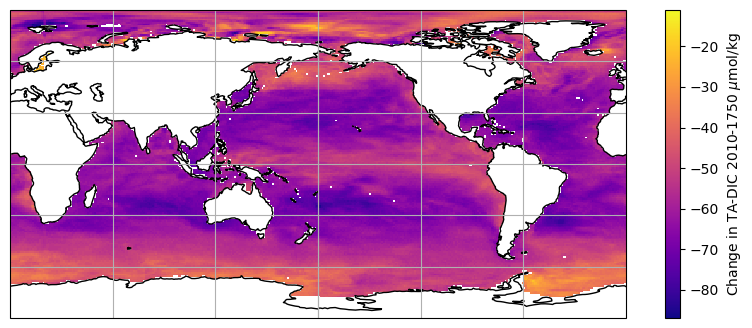

In [5]:
# Change in TA-DIC (2010-1750)
alkstar_1750 = ds.talk_1750 - ds.dic_1750
alkstar_2010 = ds.talk_2010 - ds.dic_2010
alkstar_dif = alkstar_2010 - alkstar_1750
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
cmap = plt.get_cmap('plasma')
hplt = alkstar_dif.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), cmap=cmap
)
hcb = hplt.colorbar
hcb.set_label(r'Change in TA-DIC 2010-1750 $\mu$mol/kg')
# cb.set_label("CH4 Concentration (ppm)",fontsize=6, rotation=0)
ax.coastlines(resolution='110m')
ax.gridlines();

## Map the array of "dist2coast" to be used to select grid cells within specified distances of the nearest coast 

The "dist2coast" array indicates distance in kilometers from the grid cell to the nearest coast. In a later section we will demonstrate how to use this array to select a subset of grid cells to analyze. 

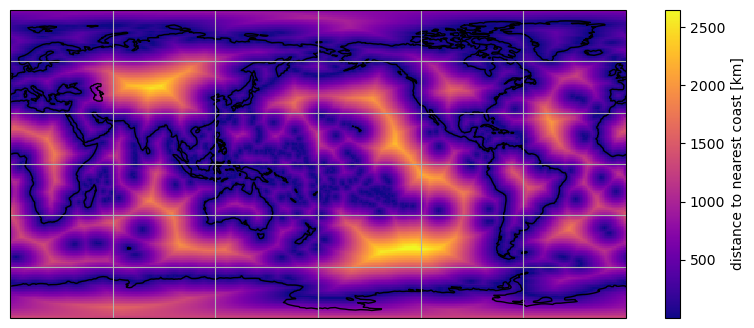

In [6]:
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
cmap = plt.get_cmap('plasma')
ds.dist2coast.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), cmap=cmap
)
ax.coastlines(resolution='110m')
ax.gridlines();

## Map the array of "LME" codes to be used to select grid cells inside of Large Marine Ecosystems 

The "LME" array contains integer codes numbered 1-66 to indicate whether the grid cells are located within 1 of the 66 global Large Marine Ecosystems (LME). The names of the LME for each code are described below. We will show how to use the "LME" array to select a subset of grid cells to analyze.

**LME numbers 1-66**

0 not in a LME, 1	Agulhas Current, 2	Aleutian Islands, 3	Antarctica, 4	Arabian Sea, 5	Baltic Sea, 6	Barents Sea, 7	Bay Of Bengal, 8	Beaufort Sea, 9	Benguela Current, 10	Black Sea, 11	California Current, 12	Canadian Eastern Arctic/West Greenland, 13	Canadian High Arctic/North Greenland, 14	Canary Current, 15	Caribbean Sea, 16	Celtic Biscay Shelf, 17	Central Arctic, 18	East Bering Sea, 19	East Brazil Shelf, 20	East Central Australian Shelf, 21	East China Sea, 22	East Siberian Sea, 23	Faroe Plateau, 24	Greenland Sea, 25	Guinea Current, 26	Gulf Of Alaska, 27	Gulf Of California, 28	Gulf Of Mexico, 29	Gulf Of Thailand, 30	Hudson Bay Complex, 31	Humboldt Current, 32	Iberian Coastal, 33	Iceland Shelf And Sea, 34	Indonesian Shelf, 35	Insular Pacific/Hawaiian, 36	Kara Sea, 37	Kuroshio Current, 38	Labrador/Newfoundland, 39	Laptev Sea, 40	Mediterranean Sea, 41	New Zealand Shelf, 42	North Australian Shelf, 43	North Brazil Shelf, 44	North Sea, 45	Northeast Australian Shelf, 46	Northeast US Continental Shelf, 47	Northern Bering/Chukchi Seas, 48	Northwest Australian Shelf, 49	Norwegian Sea, 50	Oyashio Current, 51	Pacific Central American Coastal, 52	Patagonia Shelf, 53	Red Sea, 54	Scotian Shelf, 55	Sea Of Japan, 56	Sea Of Okhotsk, 57	Somali Coastal Current, 58	South Brazil Shelf, 59	South China Sea, 60	Southeast Australian Shelf, 61	Southeast US Continental Shelf, 62	Southwest Australian Shelf, 63	Sulu Celebes Sea, 64	West Australian Shelf, 65	West Bering Sea, 66	Yellow Sea


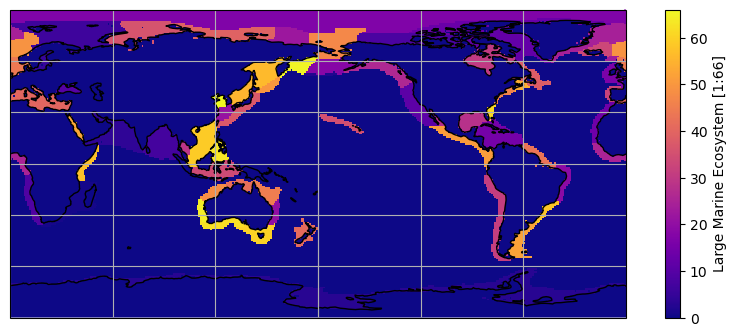

In [7]:
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
cmap = plt.get_cmap('plasma')
# cmap = plt.get_cmap('plasma').reversed()
ds.LME.plot(
    x="lon", y="lat", transform=ccrs.PlateCarree(), cmap=cmap
)
ax.coastlines(resolution='110m')
ax.gridlines();

# Copy the dask arrays to a dictionary 

The computations are most efficient using numpy arrays in a data dictionary. This next step will copy the dataset of dask arrays from the previous step into a data dictionary of numpy arrays that we will use for the computations.

In [8]:
# Convert ds to dictionary
ds_dict = {var: ds[var].values for var in ds.data_vars}

# Evaluate $\Delta$TA needed to restore TA-DIC to pre-industrial

Now we are ready to calculate the amount of $\Delta$TA needed to restore the objective variable to pre-industrial conditons. In this example we will use the TA-DIC (alkstar) as the objective variable. We will evaluate the $\Delta$TA needed to restore TA-DIC to pre-industrial with following four scenarios:

- a) OAE using NaOH and 0% CDReff
- b) OAE using Na2CO3 and 0% CDReff
- d) OAE using NaOH and 80% CDReff
- d) OAE using Na2CO3 and 80% CDReff

It is important to be selective about which grid cells are being evaluated because the computations take up to a few seconds for each grid cell. Therefore if we do the computations on every grid cell in the entire 360 x 180 grid, the computations would require hours of CPU time. If instead we select the grid cells within the coastal zone of one or two LMEs, the computations only require up to a few minutes of CPU time. Therefore it is best to be selective about which grid cells to evaluate to avoid wasting unnecessary CPU time.

In the next step we will select the subset of grid cells within the California Current Ecosystem that are within 100km of the nearest shore for computation. The subset of grid cells to evaluate can be easily changed by the user by changing the if statement in code section 2 below, for example by filtering with any "LME" that is needed for the analysis, either with or without also including the "dist2coast" array to restrict the analysis to within any distance from the nearest coast.

Note that there are three code sections identified in the code below where we will make selections to specify the following:

- SECTION 1:
    - specify the name of the new data dictionary array for the output file and intialize the values as nan
    - specify which objective variable to analyze (either 'alkstar', 'co3', phtot', 'omara', or 'omcal')
        - alkstar: TA-DIC umol/kg
        - co3: carbonate ion umol/kg
        - phtot: pH (total scale)
        - omara: aragonite saturation state
        - omcal: calcite saturation state
    - specify which chemical to use for OAE (either 'NaOH' or 'Na2CO3')
    - specify the assumed CDR efficiency as a value between 0-1 (e.g. use 0.8 to assume 80% CDR efficiency)
    - specify the upper and lower bounds of the range of dTA values that the brentq algorithm will search within
- SECTION 2:
    - edit the if statement to select which subset of grid cells to analyze, for example using the dist2coast and LME arrays as selectors. For example, to analyze a subset of grid cells in the California Current Ecosystem within 100km of the coast, the following if statement would work:
        - if ds_dict["dist2coast"][i,j]<=100 and ds_dict["LME"][i,j]==11:
- SECTION 3: edit the name of the output array in the data dictionary as needed to match the array name that was initialized in SECTION 1

The main analysis loop takes a few minutes to loop through all of the grid cells and for each of the four scenarios listed above

First we will define a function that will be used repeatedly in the main analysis loop. This function extracts the chemistry data from 1750 and 2010 at the current i,j coordinates that are being evaluated, and makes the kwargs for the brentq function calls in the main analysis loop through all of the grid cells.

In [9]:
def make_kwargs(ds_dict, i, j, oae_type, obj_var, cdreff):
    chem_pi = np.full(7, np.nan)
    chem_pi[0] = ds_dict["talk_1750"][i,j]
    chem_pi[1] = ds_dict["dic_1750"][i,j]
    chem_pi[2] = ds_dict["sio3"][i,j]
    chem_pi[3] = ds_dict["po4"][i,j]
    chem_pi[4] = ds_dict["temp_1750"][i,j]
    chem_pi[5] = ds_dict["sal_1750"][i,j]        
    chem_pi[6] = 0
    chem_ctl = np.full(7, np.nan)
    chem_ctl[0] = ds_dict["talk_2010"][i,j]
    chem_ctl[1] = ds_dict["dic_2010"][i,j]
    chem_ctl[2] = ds_dict["sio3"][i,j]
    chem_ctl[3] = ds_dict["po4"][i,j]
    chem_ctl[4] = ds_dict["temp_2010"][i,j]
    chem_ctl[5] = ds_dict["sal_2010"][i,j]
    chem_ctl[6] = 0
    kwargs = {
        'chem_pi': chem_pi,
        'chem_ctl': chem_ctl,
        'oae_type': oae_type,
        'obj_var': obj_var,
        'cdreff': cdreff
        }
    return chem_pi, chem_ctl, kwargs

Now we are ready to do the analysis loop through all of the grid cells for each of the four scenarios in the next section of code. Running the next section of code will take a few minutes to do all of the computations.

In [10]:
tic()

# a) 
#
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# USER OPTIONS - SECTION 1
# general user inputs to intialize the output array and select options
ds_dict["dTA_alkstar_NaOH_cdreff0"] = np.full((180, 360), np.nan) # init out array 
obj_var = 'alkstar'   # 'alkstar', 'co3', phtot', 'omara', or 'omcal'
oae_type = 'NaOH'     # 'NaOH' or 'Na2CO3'
cdreff = 0.0          # CDRefficiency between 0-1 (e.g. 0.8 = 80%)
x_upr = 0   # lower bound of the range of dTA values (umol/kg) to search for the root
x_lwr = 500 # upper bound of the range of dTA values (umol/kg) to search for the root
# end of section 1
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
print("Computing ...")
print("obj_var:",obj_var,"| oae_type:",oae_type,"| cdreff:",cdreff)
# main loop through all grid cells
for i, j in np.ndindex((180,360)):
    #
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # USER OPTIONS - SECTION 2
    # user customize if statement to select the subset of grid cells to evaluate
    if ds_dict["dist2coast"][i,j]<=100 and ds_dict["LME"][i,j]==11:   # coastal CCE
        # end of section 2
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        chem_pi, chem_ctl, kwargs = make_kwargs(ds_dict, i, j, oae_type, obj_var, cdreff)
        nnn_pi = np.count_nonzero(~np.isnan(chem_pi))  # number of non-nan values
        nnn_ctl = np.count_nonzero(~np.isnan(chem_ctl))  # number of non-nan values
        if nnn_pi==7 and nnn_ctl==7:
            f_x = lambda x: f_dTA(x, kwargs)
            root = opt.brentq(f_x, x_upr, x_lwr)
            print("i: %.0f, j: %.0f, root: %.4f" % (i,j,root))
            #
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            # USER OPTIONS - SECTION 3
            # user customize name of array to store the outputs
            ds_dict["dTA_alkstar_NaOH_cdreff0"][i,j] = root
            # end of section 3
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# b) 
#
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# USER OPTIONS - SECTION 1
# general user inputs to intialize the output array and select options
ds_dict["dTA_alkstar_Na2CO3_cdreff0"] = np.full((180, 360), np.nan) # init out array 
obj_var = 'alkstar'   # 'alkstar', 'co3', phtot', 'omara', or 'omcal'
oae_type = 'Na2CO3'     # 'NaOH' or 'Na2CO3'
cdreff = 0.0          # CDRefficiency between 0-1 (e.g. 0.8 = 80%)
x_upr = 0   # lower bound of the range of dTA values (umol/kg) to search for the root
x_lwr = 500 # upper bound of the range of dTA values (umol/kg) to search for the root
# end of section 1
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
print("Computing ...")
print("obj_var:",obj_var,"| oae_type:",oae_type,"| cdreff:",cdreff)
# main loop through all grid cells
for i, j in np.ndindex((180,360)):
    #
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # USER OPTIONS - SECTION 2
    # user customize if statement to select the subset of grid cells to evaluate
    if ds_dict["dist2coast"][i,j]<=100 and ds_dict["LME"][i,j]==11:   # coastal CCE
        # end of section 2
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        chem_pi, chem_ctl, kwargs = make_kwargs(ds_dict, i, j, oae_type, obj_var, cdreff)
        nnn_pi = np.count_nonzero(~np.isnan(chem_pi))  # number of non-nan values
        nnn_ctl = np.count_nonzero(~np.isnan(chem_ctl))  # number of non-nan values
        if nnn_pi==7 and nnn_ctl==7:
            f_x = lambda x: f_dTA(x, kwargs)
            root = opt.brentq(f_x, x_upr, x_lwr)
            print("i: %.0f, j: %.0f, root: %.4f" % (i,j,root))
            #
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            # USER OPTIONS - SECTION 3
            # user customize name of array to store the outputs
            ds_dict["dTA_alkstar_Na2CO3_cdreff0"][i,j] = root
            # end of section 3
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# c)
#
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# USER OPTIONS - SECTION 1
# general user inputs to intialize the output array and select options
ds_dict["dTA_alkstar_NaOH_cdreff80"] = np.full((180, 360), np.nan) # init out array 
obj_var = 'alkstar'   # 'alkstar', 'co3', phtot', 'omara', or 'omcal'
oae_type = 'NaOH'     # 'NaOH' or 'Na2CO3'
cdreff = 0.8          # CDRefficiency between 0-1 (e.g. 0.8 = 80%)
x_upr = 0   # lower bound of the range of dTA values (umol/kg) to search for the root
x_lwr = 500 # upper bound of the range of dTA values (umol/kg) to search for the root
# end of section 1
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
print("Computing ...")
print("obj_var:",obj_var,"| oae_type:",oae_type,"| cdreff:",cdreff)
# main loop through all grid cells
for i, j in np.ndindex((180,360)):
    #
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # USER OPTIONS - SECTION 2
    # user customize if statement to select the subset of grid cells to evaluate
    if ds_dict["dist2coast"][i,j]<=100 and ds_dict["LME"][i,j]==11:   # coastal CCE
        # end of section 2
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        chem_pi, chem_ctl, kwargs = make_kwargs(ds_dict, i, j, oae_type, obj_var, cdreff)
        nnn_pi = np.count_nonzero(~np.isnan(chem_pi))  # number of non-nan values
        nnn_ctl = np.count_nonzero(~np.isnan(chem_ctl))  # number of non-nan values
        if nnn_pi==7 and nnn_ctl==7:
            f_x = lambda x: f_dTA(x, kwargs)
            root = opt.brentq(f_x, x_upr, x_lwr)
            print("i: %.0f, j: %.0f, root: %.4f" % (i,j,root))
            #
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            # USER OPTIONS - SECTION 3
            # user customize name of array to store the outputs
            ds_dict["dTA_alkstar_NaOH_cdreff80"][i,j] = root
            # end of section 3
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# d) 
#
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# USER OPTIONS - SECTION 1
# general user inputs to intialize the output array and select options
ds_dict["dTA_alkstar_Na2CO3_cdreff80"] = np.full((180, 360), np.nan) # init out array 
obj_var = 'alkstar'   # 'alkstar', 'co3', phtot', 'omara', or 'omcal'
oae_type = 'Na2CO3'     # 'NaOH' or 'Na2CO3'
cdreff = 0.8          # CDRefficiency between 0-1 (e.g. 0.8 = 80%)
x_upr = 0   # lower bound of the range of dTA values (umol/kg) to search for the root
x_lwr = 500 # upper bound of the range of dTA values (umol/kg) to search for the root
# end of section 1
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
print("Computing ...")
print("obj_var:",obj_var,"| oae_type:",oae_type,"| cdreff:",cdreff)
# main loop through all grid cells
for i, j in np.ndindex((180,360)):
    #
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # USER OPTIONS - SECTION 2
    # user customize if statement to select the subset of grid cells to evaluate
    if ds_dict["dist2coast"][i,j]<=100 and ds_dict["LME"][i,j]==11:   # coastal CCE
        # end of section 2
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        chem_pi, chem_ctl, kwargs = make_kwargs(ds_dict, i, j, oae_type, obj_var, cdreff)
        nnn_pi = np.count_nonzero(~np.isnan(chem_pi))  # number of non-nan values
        nnn_ctl = np.count_nonzero(~np.isnan(chem_ctl))  # number of non-nan values
        if nnn_pi==7 and nnn_ctl==7:
            f_x = lambda x: f_dTA(x, kwargs)
            root = opt.brentq(f_x, x_upr, x_lwr)
            print("i: %.0f, j: %.0f, root: %.4f" % (i,j,root))
            #
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            # USER OPTIONS - SECTION 3
            # user customize name of array to store the outputs
            ds_dict["dTA_alkstar_Na2CO3_cdreff80"][i,j] = root
            # end of section 3
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

toc()

Computing ...
obj_var: alkstar | oae_type: NaOH | cdreff: 0.0
i: 112, j: 249, root: 49.0000
i: 112, j: 250, root: 45.0000
i: 113, j: 248, root: 50.0000
i: 114, j: 247, root: 55.0000
i: 115, j: 247, root: 53.0000
i: 116, j: 245, root: 57.0000
i: 116, j: 246, root: 52.0000
i: 117, j: 244, root: 57.0000
i: 118, j: 241, root: 59.0000
i: 118, j: 242, root: 59.0000
i: 118, j: 243, root: 58.0000
i: 118, j: 244, root: 60.0000
i: 118, j: 245, root: 54.0000
i: 119, j: 241, root: 58.0000
i: 119, j: 242, root: 59.0000
i: 119, j: 243, root: 58.0000
i: 120, j: 243, root: 54.0000
i: 121, j: 242, root: 51.0000
i: 122, j: 240, root: 50.0000
i: 122, j: 241, root: 49.0000
i: 122, j: 242, root: 49.0000
i: 123, j: 239, root: 46.0000
i: 123, j: 240, root: 47.0000
i: 123, j: 241, root: 47.0000
i: 124, j: 238, root: 53.0000
i: 125, j: 238, root: 52.0000
i: 126, j: 237, root: 49.0000
i: 127, j: 236, root: 48.0000
i: 128, j: 235, root: 49.0000
i: 128, j: 236, root: 41.0000
i: 129, j: 235, root: 45.0000
i: 130, 

# Map the results

In the next code section we will make a figure that displays maps of the results of the four scenarios that were computed in the previous step

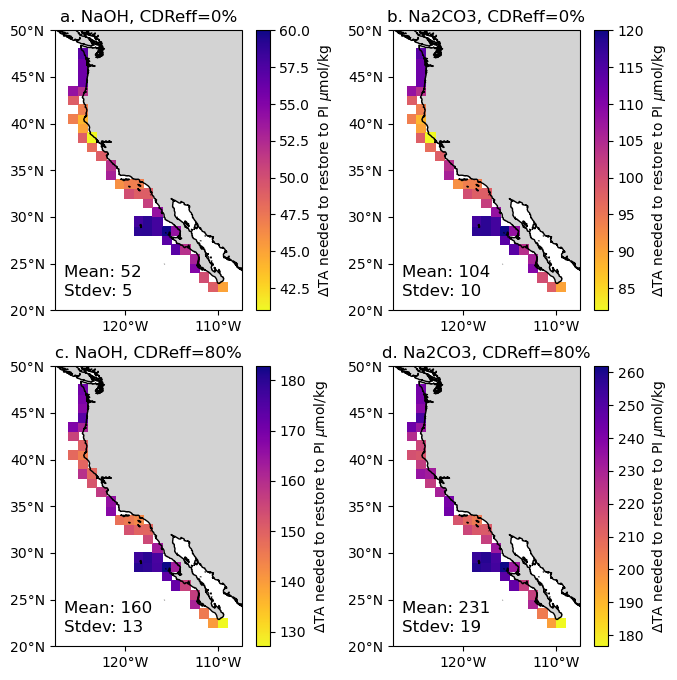

In [11]:
# Create a figure and a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# define lon and lat
lon = np.linspace(0.5, 359.5, 360)
lat = np.linspace(-89.5, 89.5, 180)
lon2d, lat2d = np.meshgrid(lon, lat)

# define ticks and labels
lon_ticks = range(-120, -100, 10)  # Longitude ticks every 30 degrees
lat_ticks = range(20, 55, 5)    # Latitude ticks every 30 degrees
xtick_labels = ['120°W', '110°W']
ytick_labels = ['20°N', '25°N', '30°N', '35°N', '40°N', '45°N', '50°N']

# - - -
# a)

data = ds_dict["dTA_alkstar_NaOH_cdreff0"]
mean = np.nanmean(ds_dict["dTA_alkstar_NaOH_cdreff0"])
stdev = np.nanstd(ds_dict["dTA_alkstar_NaOH_cdreff0"])
ax[0, 0].set_title('a. NaOH, CDReff=0%')
ax[0, 0].projection = ccrs.PlateCarree()
ax[0, 0].set_extent([-127.5+360, -107.5+360, 20, 50], crs=ccrs.PlateCarree())
ax[0, 0].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax[0, 0].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax[0, 0].set_xticklabels(xtick_labels)
ax[0, 0].set_yticklabels(ytick_labels)
ax[0, 0].add_feature(cfeature.LAND, facecolor='lightgray')
ax[0, 0].coastlines('10m', edgecolor='none')
ax[0, 0].add_feature(cfeature.BORDERS, edgecolor='none')
ax[0, 0].text(-126.5, 24, 'Mean: '+f"{mean:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
ax[0, 0].text(-126.5, 22, 'Stdev: '+f"{stdev:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
cmap1 = plt.get_cmap('plasma').reversed()
contour1 = ax[0, 0].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap1)
cbar1 = plt.colorbar(contour1, orientation='vertical', pad=0.05)
cbar1.set_label(r'$\Delta$TA needed to restore to PI $\mu$mol/kg')

# - - -
# b)

data = ds_dict["dTA_alkstar_Na2CO3_cdreff0"]
mean = np.nanmean(ds_dict["dTA_alkstar_Na2CO3_cdreff0"])
stdev = np.nanstd(ds_dict["dTA_alkstar_Na2CO3_cdreff0"])
ax[0, 1].set_title('b. Na2CO3, CDReff=0%')
ax[0, 1].projection = ccrs.PlateCarree()
ax[0, 1].set_extent([-127.5+360, -107.5+360, 20, 50], crs=ccrs.PlateCarree())
ax[0, 1].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax[0, 1].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax[0, 1].set_xticklabels(xtick_labels)
ax[0, 1].set_yticklabels(ytick_labels)
ax[0, 1].add_feature(cfeature.LAND, facecolor='lightgray')
ax[0, 1].coastlines('10m', edgecolor='none')
ax[0, 1].add_feature(cfeature.BORDERS, edgecolor='none')
ax[0, 1].text(-126.5, 24, 'Mean: '+f"{mean:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
ax[0, 1].text(-126.5, 22, 'Stdev: '+f"{stdev:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
cmap2 = plt.get_cmap('plasma').reversed()
contour2 = ax[0, 1].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap2)
cbar2 = plt.colorbar(contour2, orientation='vertical', pad=0.05)
cbar2.set_label(r'$\Delta$TA needed to restore to PI $\mu$mol/kg')

# - - -
# c)

data = ds_dict["dTA_alkstar_NaOH_cdreff80"]
mean = np.nanmean(ds_dict["dTA_alkstar_NaOH_cdreff80"])
stdev = np.nanstd(ds_dict["dTA_alkstar_NaOH_cdreff80"])
ax[1, 0].set_title('c. NaOH, CDReff=80%')
ax[1, 0].projection = ccrs.PlateCarree()
ax[1, 0].set_extent([-127.5+360, -107.5+360, 20, 50], crs=ccrs.PlateCarree())
ax[1, 0].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax[1, 0].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax[1, 0].set_xticklabels(xtick_labels)
ax[1, 0].set_yticklabels(ytick_labels)
ax[1, 0].add_feature(cfeature.LAND, facecolor='lightgray')
ax[1, 0].coastlines('10m', edgecolor='none')
ax[1, 0].add_feature(cfeature.BORDERS, edgecolor='none')
ax[1, 0].text(-126.5, 24, 'Mean: '+f"{mean:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
ax[1, 0].text(-126.5, 22, 'Stdev: '+f"{stdev:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
cmap3 = plt.get_cmap('plasma').reversed()
contour3 = ax[1, 0].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap3)
cbar3 = plt.colorbar(contour3, orientation='vertical', pad=0.05)
cbar3.set_label(r'$\Delta$TA needed to restore to PI $\mu$mol/kg')

# - - -
# d)

data = ds_dict["dTA_alkstar_Na2CO3_cdreff80"]
mean = np.nanmean(ds_dict["dTA_alkstar_Na2CO3_cdreff80"])
stdev = np.nanstd(ds_dict["dTA_alkstar_Na2CO3_cdreff80"])
ax[1, 1].set_title('d. Na2CO3, CDReff=80%')
ax[1, 1].projection = ccrs.PlateCarree()
ax[1, 1].set_extent([-127.5+360, -107.5+360, 20, 50], crs=ccrs.PlateCarree())
ax[1, 1].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax[1, 1].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax[1, 1].set_xticklabels(xtick_labels)
ax[1, 1].set_yticklabels(ytick_labels)
ax[1, 1].add_feature(cfeature.LAND, facecolor='lightgray')
ax[1, 1].coastlines('10m', edgecolor='none')
ax[1, 1].add_feature(cfeature.BORDERS, edgecolor='none')
ax[1, 1].text(-126.5, 24, 'Mean: '+f"{mean:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
ax[1, 1].text(-126.5, 22, 'Stdev: '+f"{stdev:.0f}", transform=ccrs.PlateCarree(),
        fontsize=12, color='black', ha='left', va='center')
cmap4 = plt.get_cmap('plasma').reversed()
contour4 = ax[1, 1].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap4)
cbar4 = plt.colorbar(contour4, orientation='vertical', pad=0.05)
cbar4.set_label(r'$\Delta$TA needed to restore to PI $\mu$mol/kg')

plt.show();